In [285]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.markers as mks
import numpy as np
import pprint
import random as rn
from itertools import chain
import math
import multiprocessing
import copy
import random

In [286]:
# Parameters for standard configuration
A = 10  # Alpha: maximum number of neighborhoods that a neighborhood can serve
L = 1000  # Lambda: scaling factor for total number of facilities opened
G = 15  # Gamma: penalty for unit unmet demand
k = ["Water", "Food", "Medical Kit", "Shelter"]  # commodities type
# v = dict(zip(k, [1, 1, 0.5, 38500]))  # unit volume of commodity k
cd = dict(zip(k, [2.5, 3, 0.333, 0.2]))  # commodities demand of an injured in 1day
V = 100000 # Volume Capacity of LDC

In [287]:
CMD_Coordinate = [] # [[x1,y1], [x2,y2], ...]
LDC_Coordinate = [] # [[x1,y1], [x2,y2], ...]
EC_Coordinate = [] # [[x1,y1], [x2,y2], ...]
Pop_Blocks = [] # [[x1,y1,pop1], [x2,y2,pop2], ...]
No_CMD = 0 # number of Crises Management Databases
No_LDC = 0 # number of Local Distribution Centers
No_EC = 0 # number of Evacuation Centers
CMD_name = []
LDC_name = []
EC_name = []
c_LDC = [] # capacities of LDC
EC_demand = [] # demands of EC
EC_water_demand = []
EC_food_demand = []
EC_medicalkit_demand = []
EC_shelter_demand = []
elite_Chromosom = []
elites_fitness = math.inf
bad_chromosom_index = 0
genetic_best_solution = np.nan

# Reading the CMD File
def read_CMD_file(path: str):
    global CMD_Coordinate, CMD_name, No_CMD
    with open(path, "r", encoding='utf-8') as file:
        lines = file.readlines()
    for i, line in enumerate(lines, start=1):
        if 1 < i:
            CMD_Attributes = line.split(",")
            CMD_name.append(CMD_Attributes[1])
            CMD_Coordinate.append([float(CMD_Attributes[-2]), float(CMD_Attributes[-1])])
    No_CMD = len(CMD_Coordinate)
    print(f"Number of CMDs: {No_CMD} \nCMD_Name: {CMD_name} \nCMD_Coordinate: {CMD_Coordinate}\n\n")
    file.close()

# Reading the LDC File 
def read_LDC_file(path: str):
    global LDC_Coordinate, LDC_name, No_LDC, c_LDC
    with open(path, "r", encoding='utf-8') as file:
        lines = file.readlines()
    for i, line in enumerate(lines, start=1):
        if 1 < i:
            LDC_Attributes = line.split(",")
            LDC_name.append(LDC_Attributes[5])
            LDC_Coordinate.append([float(LDC_Attributes[-2]), float(LDC_Attributes[-1])])
    No_LDC = len(LDC_Coordinate)
    c_LDC = [V]*No_LDC
    print(f"Number of LDCs: {No_LDC} \nLDC_Name: {LDC_name} \nLDC_Coordinate: {LDC_Coordinate}\n\n")
    file.close()

# Reading the EC File    
def read_EC_file(path: str):
    global EC_Coordinate, EC_name, No_EC
    with open(path, "r", encoding='utf-8') as file:
        lines = file.readlines()
    for i, line in enumerate(lines, start=1):
        if 1 < i:
            EC_Attributes = line.split(",")
            EC_name.append(EC_Attributes[2])
            EC_Coordinate.append([float(EC_Attributes[-2]), float(EC_Attributes[-1])])
    No_EC = len(EC_Coordinate)
    print(f"Number of ECs: {No_EC} \nCE_Name: {EC_name} \nCE_Coordinate: {EC_Coordinate}\n\n")
    file.close()
    
    
def read_Pop_Blocks_file(path: str):
    global Pop_Blocks
    with open(path, "r", encoding='utf-8') as file:
        lines = file.readlines()
    for i, line in enumerate(lines, start=1):
        if 1 < i:
            Pop_Blocks_Attributes = line.split(",")
            Pop_Blocks.append([float(Pop_Blocks_Attributes[-2]), float(Pop_Blocks_Attributes[-1]), float(Pop_Blocks_Attributes[37])])
    No_Pop_Blocks = len(Pop_Blocks)
    print(f"Number of Pop_Blocks: {No_Pop_Blocks}\n Pop_Blocks: {Pop_Blocks}\n\n")
    file.close()

read_CMD_file("C:\\Users\\Amir\\Desktop\\SDSS-Project\\Data\\CMD_Points.txt")
read_LDC_file("C:\\Users\\Amir\\Desktop\\SDSS-Project\\Data\\LDC_Points.txt")
read_EC_file("C:\\Users\\Amir\\Desktop\\SDSS-Project\\Data\\EC_Points.txt")
read_Pop_Blocks_file("C:\\Users\\Amir\\Desktop\\SDSS-Project\\Data\\Reg4PopBlock_Points.txt")

Number of CMDs: 7 
CMD_Name: ['حکیمیه', 'شهید عبادی', 'شهید اشرفی اصفهانی', 'پارک پلیس', 'آب شناسان', 'شهید عراقی', 'شهید بروجردی'] 
CMD_Coordinate: [[553761.069681, 3955093.22817], [549673.546283, 3954136.80222], [549439.228568, 3954121.32858], [548946.167303, 3957481.25995], [547068.365979, 3955672.87226], [541820.6491, 3955714.691], [542276.9608, 3957398.2747]]


Number of LDCs: 97 
LDC_Name: ['پیش دبستان و دبستان نهال دانش', 'مجتمع آموزشی فرهنگ منطقه 4', 'دبیرستان شهید زین الدین', 'دبستان دخترانه فردوس', 'دبیرستان سلام', 'دبستان مهارت آموز', 'مدرسه نشاط', 'مدرسه علمیه حضرت زینب کبری', 'دبستان پسرانه استاد شهريار', 'دبیرستان دوره اول علامه حلی ۲', 'دانشگاه علمی و کاربردی دکتر عبیدی', 'مجتمع آموزشی دخترانه غیردولتی زینبیه', 'دبیرستان دوره اول نمونه دولتی دخترانه سعدی۰', 'هنرستان دخترانه فسایی نژاد', 'مجتمع فرهنگی اسلامی شهدای کشتی\u200cرانی', 'دبیرستان دخترانه فرهیختگان', 'دبستان بادبادک', 'مدرسه غیر انتفاعی دخترانه صبا', 'دبیرستان پسرانه شهید مجمدعلی رجایی', 'دبستان غیردولتی دخترانه

In [288]:
import numpy as np
from scipy.spatial.distance import cdist

Pop_Blocks = np.array(Pop_Blocks)
EC_Coordinate = np.array(EC_Coordinate)
distances = cdist(Pop_Blocks[:, :2], EC_Coordinate, metric='euclidean')

# پیدا کردن اندیس نزدیک‌ترین مرکز برای هر نقطه
assigned_centers = np.argmin(distances, axis=1)
# محاسبه مجموع جمعیت برای هر مرکز
EC_pop = np.bincount(assigned_centers, weights=Pop_Blocks[:, 2])


assignments = {i: [] for i in range(158)}
for point_idx, center_idx in enumerate(assigned_centers):
    assignments[center_idx].append(point_idx)
# چاپ یا ذخیره تخصیص‌ها
# for center_idx, point_indices in assignments.items():
    # print(f"EC {center_idx}: PopBlock {point_indices}")
EC_water_demand = [cd["Water"] * p for p in EC_pop]
EC_food_demand = [cd["Food"] * p for p in EC_pop]
EC_medicalkit_demand = [cd["Medical Kit"] * p for p in EC_pop]
EC_shelter_demand = [cd["Shelter"] * p for p in EC_pop]
EC_demand = [w + f + m + s for w, f, m, s in zip(EC_water_demand, EC_food_demand, EC_medicalkit_demand, EC_shelter_demand)]

print(f"\nwater demand of ECs: {EC_water_demand}\nfood demand of ECs: {EC_food_demand}\nmedicalkit demand of ECs: {EC_medicalkit_demand}\nshelter demand of ECs: {EC_shelter_demand}\n\nvd_EC: {EC_demand}")



water demand of ECs: [20235.0, 2815.0, 59150.0, 28977.5, 45197.5, 21860.0, 225.0, 3515.0, 0.0, 20140.0, 4360.0, 11935.0, 73167.5, 11945.0, 9092.5, 11942.5, 18025.0, 11252.5, 12087.5, 0.0, 2217.5, 1862.5, 28060.0, 3997.5, 5925.0, 6612.5, 2937.5, 6440.0, 1552.5, 20635.0, 2427.5, 10627.5, 11735.0, 4655.0, 935.0, 10327.5, 847.5, 38137.5, 14285.0, 822.5, 6625.0, 25692.5, 10800.0, 55755.0, 15057.5, 16457.5, 24915.0, 3905.0, 2867.5, 25142.5, 7670.0, 4000.0, 8050.0, 12372.5, 18815.0, 4380.0, 2722.5, 955.0, 63670.0, 6615.0, 625.0, 8312.5, 9455.0, 7687.5, 24917.5, 46945.0, 20232.5, 18025.0, 12240.0, 18970.0, 12172.5, 23802.5, 7457.5, 2070.0, 4710.0, 492.5, 11540.0, 35225.0, 5970.0, 17897.5, 12917.5, 38990.0, 1837.5, 28110.0, 4827.5, 17665.0, 12917.5, 13437.5, 6657.5, 19127.5, 16345.0, 30047.5, 20250.0, 3722.5, 8990.0, 7880.0, 15357.5, 17372.5, 13310.0, 12045.0, 5475.0, 2490.0, 58512.5, 13802.5, 3050.0, 27925.0, 14522.5, 31255.0, 19297.5, 2385.0, 5992.5, 4872.5, 15775.0, 27470.0, 22255.0, 6542.5

In [289]:
cmd_ldc_ODMatrix = []
ldc_ec_ODMatrix = []

def CMD_LDC_ODMatrix(path: str):
        global cmd_ldc_ODMatrix, No_CMD, No_LDC
        cmd_ldc_ODMatrix = np.full((No_CMD, No_LDC), np.nan)
        with open(path, "r", encoding='utf-8') as file:
                lines = file.readlines()
        file.close()
        for i, line in enumerate(lines, start=1):
                if 1 < i:
                        Attributes = line.split(",")
                        OriginID = Attributes[2]
                        DestinationID = Attributes[3]
                        cmd_ldc_ODMatrix[int(OriginID)-1][int(DestinationID)-1] = float(Attributes[-1])
CMD_LDC_ODMatrix("C:\\Users\\Amir\\Desktop\\SDSS-Project\\Data\\OD_Matrix(CMDs_to_LDCs).txt")
# pprint.pprint(cmd_ldc_ODMatrix)

def LDC_EC_ODMatrix(path: str):
        global ldc_ec_ODMatrix, No_LDC, No_EC
        ldc_ec_ODMatrix = np.full((No_LDC, No_EC), np.nan)
        with open(path, "r", encoding='utf-8') as file:
                lines = file.readlines()
        file.close()
        for i, line in enumerate(lines, start=1):
                if 1 < i:
                        Attributes = line.split(",")
                        OriginID = Attributes[2]
                        DestinationID = Attributes[3]
                        ldc_ec_ODMatrix[int(OriginID)-1][int(DestinationID)-1] = float(Attributes[-1])
LDC_EC_ODMatrix("C:\\Users\\Amir\\Desktop\\SDSS-Project\\Data\\OD_Matrix(LDCs_to_ECs).txt")
np.set_printoptions(threshold=np.inf)
print(cmd_ldc_ODMatrix)


[[ 7913.77995726  7044.78680675  5193.76176826 13143.55444284
  13888.51353156 13859.99815135 11398.90875443 12165.81643487
   8098.82107121  9199.0364358   5708.73134135  5456.53182419
   5131.05524896 13888.60865578 12081.9746911  12414.48763185
  13041.08318008 13249.92583847 13777.96915496  6460.91910723
  14688.07556265 13721.65446554 13548.91090819 12849.98970157
  13153.68632231 13133.63223686 12478.0490256  12509.7308603
  14355.29907048  3913.50016902  7172.13083946 13529.24368462
  13548.91090819 13427.38669442 13856.22157392  4000.53298511
   7233.89390867  8031.16997628  8903.15837728  9012.6809105
   9114.03363917  9147.16232717  9173.9881493   9998.82367052
   9438.54067039  8409.53419266  7106.55816466  7106.55816466
   7179.42076335  7129.75660258  7172.13083946  2315.32649356
   2926.88757699  3269.48733952  4840.439015    4815.61925519
   4840.439015    4840.439015    4575.09966813 11622.28528378
   6777.21177416  5604.66673221  5636.39071833  6562.36010116
   6645.40

In [290]:
nan_cols_cmd_ldc_ODMatrix = np.where(np.all(np.isnan(cmd_ldc_ODMatrix), axis=0))[0]
# print(f"Nan cols: {nan_cols_cmd_ldc_ODMatrix}")
nan_rows_cmd_ldc_ODMatrix = np.where(np.all(np.isnan(cmd_ldc_ODMatrix), axis=1))[0]
# print(f"Nan rows: {nan_rows_cmd_ldc_ODMatrix}")

nan_cols_ldc_ec_ODMatrix = np.where(np.all(np.isnan(ldc_ec_ODMatrix), axis=0))[0]
# print(f"Nan cols: {nan_cols_ldc_ec_ODMatrix}")
nan_rows_ldc_ec_ODMatrix = np.where(np.all(np.isnan(ldc_ec_ODMatrix), axis=1))[0]
# print(f"Nan rows: {nan_rows_ldc_ec_ODMatrix}")

cmd_invalid_index = list(nan_rows_cmd_ldc_ODMatrix)
ldc_invalid_index = list(nan_rows_ldc_ec_ODMatrix)
ec_invalid_index = list(nan_cols_ldc_ec_ODMatrix)

# No_CMD -= len(cmd_invalid_index)
# No_LDC -= len(ldc_invalid_index)
# No_EC -= len(ec_invalid_index)
# CMD_Coordinate = [i for index, i in enumerate(CMD_Coordinate) if index not in cmd_invalid_index]
# LDC_Coordinate = [i for index, i in enumerate(LDC_Coordinate) if index not in ldc_invalid_index]
# EC_Coordinate = [i for index, i in enumerate(EC_Coordinate) if index not in ec_invalid_index]
# CMD_name = [i for index, i in enumerate(CMD_name) if index not in cmd_invalid_index]
# LDC_name = [i for index, i in enumerate(LDC_name) if index not in ldc_invalid_index]
# EC_name = [i for index, i in enumerate(EC_name) if index not in ec_invalid_index]

print(f"cmd_invalid_index: {cmd_invalid_index}\nldc_invalid_index: {ldc_invalid_index}\nec_invalid_index: {ec_invalid_index}")


cmd_invalid_index: []
ldc_invalid_index: []
ec_invalid_index: [12, 76]


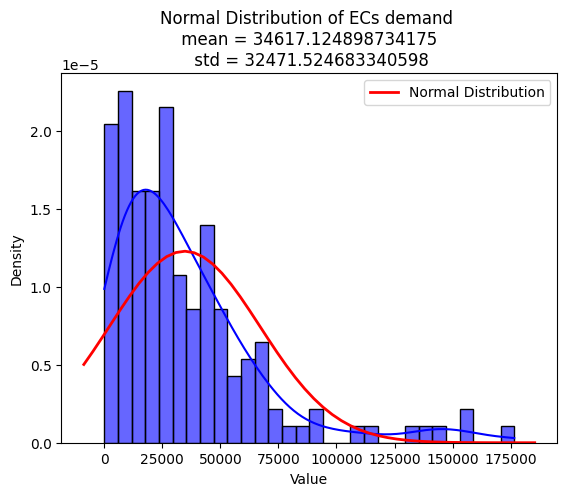

In [291]:
import seaborn as sns
from scipy.stats import norm
mu = 0
std = 0
def df_normalplot(demand_list):
    global mu, std
    sns.histplot(demand_list, bins=30, kde=True, stat="density", color="blue", alpha=0.6)
    # اضافه کردن منحنی تابع توزیع نرمال
    xmin, xmax = plt.xlim()
    mu = np.mean(demand_list)
    std = np.std(demand_list)
    x = np.linspace(xmin, xmax, 50)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'r', linewidth=2, label="Normal Distribution")

    # نمایش نمودار
    plt.legend()
    plt.title(f"Normal Distribution of ECs demand \n mean = {np.mean(demand_list)} \n std = {np.std(demand_list)}")
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.show()
        
df_normalplot(EC_demand)


In [292]:
# Initial Population
from scipy.stats import truncnorm
a, b = 0, V
a_std = (a - mu) / std
b_std = (b - mu) / std
# print(random_values)
Population = []
cmd_allowed_numbers = []
ec_allowed_numbers = []
def generate_initial_population(pop_size):
    global Population, No_LDC, cmd_invalid_index, ldc_invalid_index, ec_invalid_index, cmd_allowed_numbers, ec_allowed_numbers
    cmd_allowed_numbers = [i for i in range(No_CMD) if i not in cmd_invalid_index]
    ec_allowed_numbers = [i for i in range(No_EC) if i not in ec_invalid_index]
    for ـ in range(pop_size):
        Chromosom_part1 = []
        Chromosom_part2 = []
        # تولید مقدار تصادفی کالا برای هر LDC
        Commo_random_values = truncnorm.rvs(a_std, b_std, loc=mu*2, scale=std, size=No_LDC)
        Commodities_random_values = []
        for crvf in Commodities_random_values:
            Commodities_random_values.append(crvf*cd["Water"] + crvf*cd["Food"] + crvf*cd["Medical Kit"] + crvf*cd["Shelter"])
        Commodities_random_values_filter = [V if crv>V else crv for crv in Commo_random_values]
        for i in range(No_LDC):
            value = rn.randint(0, 1)
            if value == 0 or i in ldc_invalid_index:
                Chromosom_part1.append(0)
            else:
                cmd_rnd = rn.choice(cmd_allowed_numbers)
                commodity_amount = Commodities_random_values_filter[i]
                Chromosom_part1.append([cmd_rnd, commodity_amount])
        Chromosom_part2 = rn.choices(ec_allowed_numbers, k=No_EC)
        Population.append(Chromosom_part1 + Chromosom_part2)
    return Population
# Population = generate_initial_population(100)

In [293]:
#fitness
used_CMD_index = []
opened_LDC_index = []
used_EC_index = []
unmet_demand = np.NaN
additional_inventory = np.NaN
sum_dist = np.NaN
sum_opened_LDC = np.NaN
sum_EC_notserved = np.NaN
CMDs_to_LDCs_allocation = {f"{i}":[] for i in range(No_CMD)}
LDCs_to_ECs_dist_allocation = {f"{i}":[] for i in range(No_LDC)}

def fitness(pop):
    global elite_Chromosom, elites_fitness, bad_chromosom_index, unmet_demand, additional_inventory, sum_dist, sum_opened_LDC, sum_EC_notserved, CMDs_to_LDCs_allocation, LDCs_to_ECs_dist_allocation
    fitness_list = []
    for chromosom in pop: 
        CMDs_to_LDCs_allocation = {f"{i}":[] for i in range(No_CMD)}
        LDCs_to_ECs_dist_allocation = {f"{i}":[] for i in range(No_LDC)}
        used_CMD_index = []
        opened_LDC_index = []
        used_EC_index = []
        EC_demand_list = [-1]*No_EC
        ecd = []
        used_LDC_inventory_list = []
        CMDs_to_LDCs_dist = []
        LDCs_to_ECs_dist = []
        for index, i in enumerate(chromosom[No_LDC:]):
            if index in chromosom[No_LDC:]:
                EC_demand_list[index]  = EC_demand[index]
                ecd.append(EC_demand[index])
            used_EC_index.append(i)
        for index, i in enumerate(chromosom[:No_LDC]):
            if type(i) == list:
                opened_LDC_index.append(index)
                used_LDC_inventory_list.append(i[1])
                used_CMD_index.append(i[0])
        if sum(ecd) - sum(used_LDC_inventory_list) > 0:
            unmet_demand = sum(ecd) - sum(used_LDC_inventory_list)
            additional_inventory = 0
        elif sum(ecd) - sum(used_LDC_inventory_list) < 0:
            unmet_demand = 0
            additional_inventory = sum(used_LDC_inventory_list) - sum(ecd)
        else:
            unmet_demand = 0
            additional_inventory = 0
        # print(f"used CMDs index: {used_CMD_index}\nopened LDCs index: {opened_LDC_index}\nused LDCs inventory: {used_LDC_inventory_list}\nused Ecs index: {used_EC_index}\nused ECs demand: {EC_demand_list}\n")
        for i in range(len(used_CMD_index)):
            CMDs_to_LDCs_dist.append(cmd_ldc_ODMatrix[used_CMD_index[i]][opened_LDC_index[i]])
            CMDs_to_LDCs_allocation[f"{used_CMD_index[i]}"].append(opened_LDC_index[i])
        # print(f"CMDs_to_LDCs_dist: {CMDs_to_LDCs_dist}")
        k = 0
        NOT_DEMAND = False
        for i in range(A):
            for j in range(len(opened_LDC_index)):
                K = k
                if used_LDC_inventory_list[j] == 0:
                    continue
                while EC_demand_list[used_EC_index[k]] == 0:
                    k += 1
                    if k == len(EC_demand_list):
                        k = 0
                    if k == K:
                        NOT_DEMAND = True
                        break
                if NOT_DEMAND == True:
                    break
                if used_LDC_inventory_list[j] > EC_demand_list[used_EC_index[k]]:
                    used_LDC_inventory_list[j] -= EC_demand_list[used_EC_index[k]]
                    EC_demand_list[used_EC_index[k]] = 0
                    LDCs_to_ECs_dist.append(ldc_ec_ODMatrix[opened_LDC_index[j]][used_EC_index[k]])
                    LDCs_to_ECs_dist_allocation[f"{opened_LDC_index[j]}"].append(used_EC_index[k])
                elif used_LDC_inventory_list[j] < EC_demand_list[used_EC_index[k]]:
                    EC_demand_list[used_EC_index[k]] -= used_LDC_inventory_list[j]
                    used_LDC_inventory_list[j] = 0
                    LDCs_to_ECs_dist.append(ldc_ec_ODMatrix[opened_LDC_index[j]][used_EC_index[k]])
                    LDCs_to_ECs_dist_allocation[f"{opened_LDC_index[j]}"].append(used_EC_index[k])
                elif used_LDC_inventory_list[j] == EC_demand_list[used_EC_index[k]]:
                    used_LDC_inventory_list[j] = 0
                    EC_demand_list[used_EC_index[k]] = 0
                    LDCs_to_ECs_dist.append(ldc_ec_ODMatrix[opened_LDC_index[j]][used_EC_index[k]])
                    LDCs_to_ECs_dist_allocation[f"{opened_LDC_index[j]}"].append(used_EC_index[k])
                k += 1
                if k == len(EC_demand_list):
                        k = 0
            if NOT_DEMAND == True:
                break                  
        # print(f"LDCs_to_ECs_dist: {LDCs_to_ECs_dist}")

        sum_dist = sum(CMDs_to_LDCs_dist) + sum(LDCs_to_ECs_dist)
        sum_opened_LDC = len(opened_LDC_index)
        sum_EC_notserved = sum(1 for i in range(No_EC) if i not in chromosom[No_LDC:])
        fitness_list.append(sum_dist + sum_opened_LDC*10000 + sum_EC_notserved*10000 + unmet_demand + additional_inventory)
        # print(f"\nsum_dist: {sum_dist}\nsum_opened_LDC: {sum_opened_LDC}\nsum_EC_notserved: {sum_EC_notserved}\nunmet_demand: {unmet_demand}\nadditional_inventory: {additional_inventory}")
        # print(f"ec_demand_list: {EC_demand_list}\nused_LDC_inventory_list: {used_LDC_inventory_list}\n")
    bad_chromosom_index = fitness_list.index(max(fitness_list))
    if min(fitness_list) < elites_fitness:
        elites_fitness = min(fitness_list)
        elite_Chromosom = pop[fitness_list.index(min(fitness_list))]    
    return fitness_list

# fitness_list = fitness([Population[0]])
# print(fitness_list)
# print(CMDs_to_LDCs_allocation)
# print(LDCs_to_ECs_dist_allocation)

In [294]:
# Split Rank Selection
def SRS_Selection(ChromosomsFitness: list):
    global Ranking, ProbsRange
    selectedchromosomforcrossover = []
    SelectedChromosomForCrossOver = []
    ChromosomsFitnessSorted = sorted(ChromosomsFitness, reverse=True)
    # print(ChromosomsFitnessSorted)
    ChromosomsIndexByFitness = [ChromosomsFitness.index(i) for i in ChromosomsFitnessSorted]
    for _ in Ranking:
        r = rn.uniform(0,1)
        for index, j in enumerate(ProbsRange):
            if r > j[0] and r <= j[1]:
                selectedchromosomforcrossover.append(ChromosomsIndexByFitness[index])
                if len(selectedchromosomforcrossover) == 2:
                    SelectedChromosomForCrossOver.append(selectedchromosomforcrossover)
                    selectedchromosomforcrossover = []
                    break
    return SelectedChromosomForCrossOver
# selectedcrossover = SRS_Selection(fitness_list)

In [295]:
# New Crossover
def New_Crossover(pop, selectedcrossover):
    global No_LDC, No_EC
    childs = []
    for i1, i2 in selectedcrossover:
        if rn.uniform(0, 1) <= 0.9:
            for p1, p2 in [(pop[i1], pop[i2]), (pop[i2], pop[i1])]:
                # part 1
                ch_part1, p1_part1, p2_part1 = [-1] * No_LDC, p1[:No_LDC], p1[:No_LDC]
                rn1, rn2 = rn.randint(0, No_LDC), rn.randint(0,No_LDC)
                rn1, rn2 = min(rn1, rn2), max(rn1, rn2)
                ch_part1[rn1:rn2] = p1_part1[rn1:rn2]
                ch_part1[:rn1], ch_part1[rn2:] = p2_part1[:rn1], p2_part1[rn2:]
                
                # part 2
                ch_part2, p1_part2, p2_part2 = [-1] * No_EC, p1[No_LDC:], p2[No_LDC:]
                rn1, rn2 = rn.randint(1, No_EC // 2), rn.randint(No_EC // 2, No_EC - 2)
                joint = [r for r in range(rn1, rn2 + 1) if p1_part2[r] in p2_part2[rn1:rn2 + 1]]
                for r in joint:
                    ch_part2[r] = p1_part2[r]
                for j in joint:
                    if ch_part2[j-1] == -1 and p2_part2[j-1] not in ch_part2:
                        ch_part2[j-1] = p2_part2[j-1]
                    if ch_part2[j+1] == -1 and p2_part2[j+1] not in ch_part2:
                        ch_part2[j+1] = p2_part2[j+1]
                c = 0
                for index, l in enumerate(ch_part2):
                    if l == -1:
                        ch_part2[index] = p2_part2[c]
                        c += 1
                # print(f"ch_part1: {ch_part1}\n ch_part2: {ch_part2}\n")
                childs.append(ch_part1+ch_part2)
        else:
            childs.extend([pop[i1], pop[i2]])
    return childs
# New_Crossover(selectedcrossover)

# Two_Point_Crossover
def Two_Point_Crossover(pop, selectedcrossover, probability):
    global No_LDC, No_EC
    childs = []
    for i1, i2 in selectedcrossover:
        if rn.uniform(0, 1) <= probability:
            for p1, p2 in [(pop[i1], pop[i2]), (pop[i2], pop[i1])]:
                # part 1
                ch_part1, p1_part1, p2_part1 = [-1] * No_LDC, p1[:No_LDC], p1[:No_LDC]
                rn1, rn2 = rn.randint(0, No_LDC), rn.randint(0, No_LDC)
                rn1, rn2 = min(rn1, rn2), max(rn1, rn2)
                ch_part1[rn1:rn2] = p1_part1[rn1:rn2]
                ch_part1[:rn1], ch_part1[rn2:] = p2_part1[:rn1], p2_part1[rn2:]
                
                # part 2
                ch_part2, p1_part2, p2_part2 = [-1] * No_EC, p1[No_LDC:], p2[No_LDC:]
                rn1, rn2 = rn.randint(0, No_EC), rn.randint(0, No_EC)
                rn1, rn2 = min(rn1, rn2), max(rn1, rn2)
                ch_part2[rn1:rn2] = p1_part2[rn1:rn2]
                ch_part2[:rn1], ch_part2[rn2:] = p2_part2[:rn1], p2_part2[rn2:]
                # print(f"ch_part1: {ch_part1}\n ch_part2: {ch_part2}\n")
                childs.append(ch_part1+ch_part2)
        else:
            childs.extend([pop[i1], pop[i2]])
    return childs
# Two_Point_Crossover

# Single_Point_Crossover
def Single_Point_Crossover(pop, selectedcrossover, probability):
    global No_LDC, No_EC
    childs = []
    for i1, i2 in selectedcrossover:
        if rn.uniform(0, 1) <= probability:
            for p1, p2 in [(pop[i1], pop[i2]), (pop[i2], pop[i1])]:
                # part 1
                ch_part1, p1_part1, p2_part1 = [-1] * No_LDC, p1[:No_LDC], p1[:No_LDC]
                rnd = rn.randint(0, No_LDC)
                ch_part1[:rnd], ch_part1[rnd:] = p1_part1[:rnd], p2_part1[rnd:]
                
                # part 2
                ch_part2, p1_part2, p2_part2 = [-1] * No_EC, p1[No_LDC:], p2[No_LDC:]
                rnd = rn.randint(0, No_EC)
                ch_part2[:rnd], ch_part2[rnd:] = p1_part2[:rnd], p2_part2[rnd:]
                # print(f"ch_part1: {ch_part1}\n ch_part2: {ch_part2}\n")
                childs.append(ch_part1+ch_part2)
        else:
            childs.extend([pop[i1], pop[i2]])
    return childs
# Single Point Crossover

In [296]:
# Mutation
def Mutation(childs: list, probability):
    childsaftermutation = []
    for i in childs:
        r = rn.uniform(0,1)
        if r <= probability:
            rnd_p1 = rn.sample(list(range(No_LDC)),2)
            rnd0 = i[rnd_p1[0]]
            rnd1 = i[rnd_p1[1]]
            i[rnd_p1[0]] = rnd1
            i[rnd_p1[1]] = rnd0
                        
            rnd_p2 = rn.sample(list(range(No_LDC, No_EC)),2)
            rnd0 = i[rnd_p2[0]]
            rnd1 = i[rnd_p2[1]]
            i[rnd_p2[0]] = rnd1
            i[rnd_p2[1]] = rnd0
            childsaftermutation.append(i)
        else:
            childsaftermutation.append(i)
    return childsaftermutation

# mutation = Mutation(ch)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

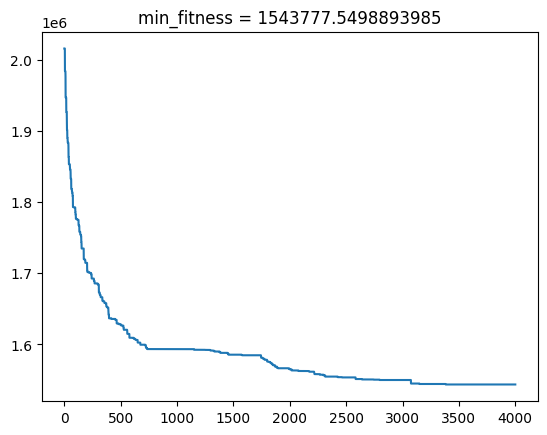

Genetic Best Solution =  [[4, 91383.69574679204], [3, 80584.74610194474], [3, 47283.0162243692], 0, [5, 44209.61811484396], [5, 98895.91713474825], [6, 100000], [6, 71436.57186322143], 0, [4, 78440.3360866978], 0, [1, 95784.26503031066], 0, 0, [6, 100000], 0, 0, 0, 0, 0, 0, [6, 51721.873194232496], [5, 37327.84891769354], 0, 0, 0, 0, [6, 88766.44997585229], 0, 0, 0, 0, 0, 0, 0, 0, 0, [4, 60765.75636094381], [3, 45540.87146290367], [4, 72523.39814236663], [5, 68065.94880867717], 0, 0, 0, 0, [3, 86291.25483505937], [4, 97242.21734740993], [4, 61234.97176141411], [6, 39555.791929473], 0, [0, 90115.1697183527], 0, 0, [0, 52198.65327139753], [1, 97150.19525055199], [1, 94579.5270769128], [0, 78262.39576272578], 0, [0, 59554.87269797934], 0, 0, [2, 77075.96637199156], 0, [1, 100000], [2, 75320.95723799132], [2, 56385.82080836625], [2, 100000], 0, [3, 69790.8980801412], [4, 92416.11601863867], 0, 0, 0, 0, 0, 0, [3, 73217.19121769551], [0, 100000], 0, [3, 60948.09256228137], [3, 56507.26522398

In [297]:
Ranking = []
ChromosomsProb =[]
ProbsRange = []
def Generation(repeat):
    global genetic_best_solution, Ranking, ChromosomsProb, ProbsRange, elite_Chromosom, bad_chromosom_index
    Population = generate_initial_population(100)
    g = range(1,repeat+1)
    minfit = []
    Ranking = range(1,len(Population)+1)
    K = len(Ranking)
    for i in Ranking:
        if i <= K/2:
            ChromosomsProb.append((12*i)/(5*K*(K+2)))
        else:
            ChromosomsProb.append((28*i)/(5*K*(3*K+2)))
    for index, i in enumerate(ChromosomsProb):
        if index == 0:
            ProbsRange.append([0,i])
        else:
            ProbsRange.append([ProbsRange[index-1][1], ProbsRange[index-1][1] + (i)])
    for i in range(repeat):
        print(i)
        Fitness = fitness(Population)
        minfit.append(min(Fitness) if (min(Fitness) <= elites_fitness) else elites_fitness)
        SelectedChromosoms = SRS_Selection(Fitness)
        Childs = Two_Point_Crossover(Population, SelectedChromosoms, 0.8)
        childsaftermutation = Mutation(Childs, 0.2)
        Population = childsaftermutation
        Population[bad_chromosom_index] = elite_Chromosom
    # Chromosom_Plot(InitialChromosoms[Fitness(InitialChromosoms).index(min(Fitness(InitialChromosoms)))])
    best_solution = Population[fitness(Population).index(min(fitness(Population)))]
    plt.plot(g,minfit)
    plt.title(f'min_fitness = {minfit[-1]}')
    plt.show()
    return best_solution
genetic_best_solution = Generation(4000)
fitness([genetic_best_solution])
print("Genetic Best Solution = ", genetic_best_solution)
print(f"Unmet Demand = {unmet_demand}\nAdditional Inventory = {additional_inventory}\nSum Distance = {sum_dist}\nSum Opened LDC = {sum_opened_LDC}\nSum EC Not Served = {sum_EC_notserved}")

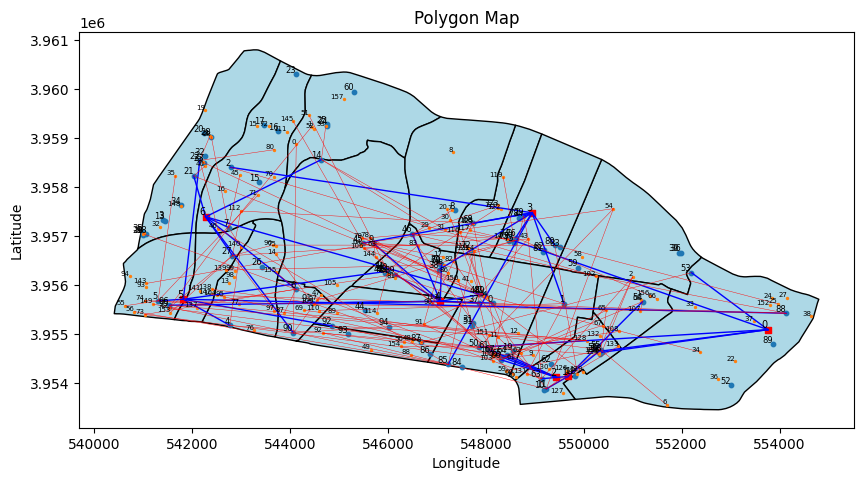

In [298]:
def BestChromosom_Plot():
    global CMDs_to_LDCs_allocation, LDCs_to_ECs_dist_allocation
    # display shp file
    shapefile_path = "C:\\Users\\Amir\\Desktop\\SDSS-Project\\Data\\Mahallat\\Reg_4.shp"
    polygons = gpd.read_file(shapefile_path)
    # print(polygons.head())
    polygons.plot(edgecolor='black', facecolor='lightblue', figsize=(10, 8))
    plt.title("Polygon Map")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    
    # display nodes
    x_cmd = []
    y_cmd = []
    x_ldc = []
    y_ldc = []
    x_ec = []
    y_ec = []
    for i in CMD_Coordinate:
        x_cmd.append(i[0])
        y_cmd.append(i[1])
    plt.scatter(x_cmd, y_cmd, c='r', s=15, marker='s')
    for n in range(No_CMD):
        plt.text(x_cmd[n], y_cmd[n], n, fontsize=7, ha='right', va='bottom')
    for i in LDC_Coordinate:
        x_ldc.append(i[0])
        y_ldc.append(i[1])
    plt.scatter(x_ldc, y_ldc, s=10)
    for n in range(No_LDC):
        plt.text(x_ldc[n], y_ldc[n], n, fontsize=6, ha='right', va='bottom')
    for i in EC_Coordinate:
        x_ec.append(i[0])
        y_ec.append(i[1])
    plt.scatter(x_ec, y_ec, s=2)
    for n in range(No_EC):
        plt.text(x_ec[n], y_ec[n], n, fontsize=5, ha='right', va='bottom')

    # display allocation nodes
    for kv in zip(CMDs_to_LDCs_allocation.keys(), CMDs_to_LDCs_allocation.values()):
        key = int(kv[0])
        value = kv[1]
        for v in value:
            plt.plot([x_cmd[key], x_ldc[v]], [y_cmd[key], y_ldc[v]], color='blue', linewidth=1)
    for kv in zip(LDCs_to_ECs_dist_allocation.keys(), LDCs_to_ECs_dist_allocation.values()):
        key = int(kv[0])
        value = kv[1]
        for v in value:
            plt.plot([x_ldc[key], x_ec[v]], [y_ldc[key], y_ec[v]], color='red', linewidth=0.3)
BestChromosom_Plot()


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

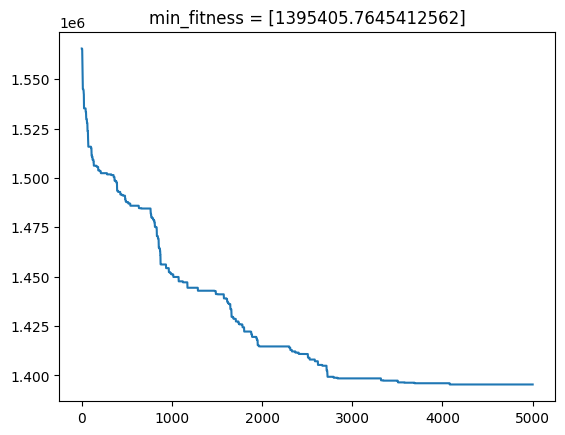

Best Solution =  ([[1, 97150.19525055199], [4, 78440.3360866978], [3, 56507.265223982205], 0, [5, 44209.61811484396], [5, 100000], [5, 98895.91713474825], [6, 71436.57186322143], 0, [6, 88766.44997585229], 0, 0, [1, 94579.5270769128], 0, [6, 100000], 0, 0, 0, 0, 0, 0, [6, 51721.873194232496], [6, 39555.791929473], 0, 0, 0, 0, [6, 100000], 0, 0, 0, 0, 0, 0, 0, 0, [3, 69790.8980801412], [4, 40973.063127612884], [4, 72523.39814236663], [4, 92416.11601863867], [4, 60765.75636094381], 0, 0, 0, 0, 0, [4, 97242.21734740993], [3, 86291.25483505937], [3, 45540.87146290367], 0, [4, 91383.69574679204], 0, 0, [0, 78262.39576272578], [1, 95784.26503031066], [0, 90115.1697183527], 0, [0, 52198.65327139753], [0, 59554.87269797934], 0, 0, [2, 77075.96637199156], 0, [0, 100000], [2, 75320.95723799132], [2, 56385.82080836625], [1, 100000], 0, 0, 0, [4, 61234.97176141411], [3, 80584.74610194474], 0, 0, [3, 73217.19121769551], 0, 0, [3, 60948.09256228137], [3, 100000], 0, [3, 47283.0162243692], 0, 0, 0, 0

In [299]:
def generate_neighbors(current_solution, moves_iteration):
    neighbors = []
    moves = []  # برای ذخیره حرکت‌ها
    unused_ec_index = [i for i in range(No_EC) if i not in current_solution[No_LDC:]]
    # حرکت نوع 1: جابجایی در بخش اول
    for _ in range(moves_iteration):
        neighbor = copy.deepcopy(current_solution)
        i, j = rn.sample(range(No_LDC), 2)
        neighbor[i], neighbor[j] = neighbor[j], neighbor[i]
        neighbors.append(neighbor)
        moves.append(("par1_swap", i, j))
    # حرکت نوع 2: جابجایی در بخش اول
    for _ in range(moves_iteration):
        neighbor = copy.deepcopy(current_solution)
        i, j = rn.sample(range(No_LDC, No_LDC + No_EC), 2)
        neighbor[i], neighbor[j] = neighbor[j], neighbor[i]
        neighbors.append(neighbor)
        moves.append(("par2_swap", i, j))
    # حرکت نوع 3: افزودن یا حذف LDC
    for k in range(moves_iteration):
        k = rn.choice(range(No_LDC))
        if current_solution[k] == 0:
            neighbor = copy.deepcopy(current_solution)
            Commo_random_values = truncnorm.rvs(a_std, b_std, loc=mu*2, scale=std, size=1)
            neighbor[k] = [rn.choice(cmd_allowed_numbers), Commo_random_values if Commo_random_values > V else V]
            neighbors.append(neighbor)
            moves.append(("ChangeLDC", k, neighbor[k]))
        else:
            neighbor = copy.deepcopy(current_solution)
            neighbor[k] = 0
            neighbors.append(neighbor)
            moves.append(("ChangeLDC", k, 0))
    # حرکت نوع 4: افزودن EC انتخاب نشده
    for _ in range(sum_EC_notserved):
        k = rn.choice(range(No_LDC, No_LDC + No_EC))
        rnd_unused_ec_index = rn.choice(unused_ec_index)
        neighbor = copy.deepcopy(current_solution)
        neighbor[k] = rnd_unused_ec_index
        neighbors.append(neighbor)
        moves.append(("AddEC", neighbor[rn.choice(neighbor[No_LDC:])], rnd_unused_ec_index))

    return neighbors, moves

def tabu_search(initial_solution, max_iterations, tabu_tenure):
    current_solution = initial_solution
    best_solution = copy.deepcopy(current_solution)
    best_cost = fitness([best_solution])

    tabu_list = []  # لیست ممنوعه برای ذخیره حرکت‌ها
    bc = []
    for m in range(max_iterations):
        print(m)
        neighbors, moves = generate_neighbors(current_solution, 10)

        # فیلتر کردن همسایه‌های مجاز
        valid_neighbors = []
        valid_moves = []
        for neighbor, move in zip(neighbors, moves):
            if move not in tabu_list:
                valid_neighbors.append(neighbor)
                valid_moves.append(move)

        if not valid_neighbors:
            break  # هیچ همسایه مجازی وجود ندارد

        # ارزیابی همسایه‌ها
        neighbors_costs = [fitness([n]) for n in valid_neighbors]
        min_cost = min(neighbors_costs)
        min_index = neighbors_costs.index(min_cost)

        # به‌روزرسانی جواب فعلی
        current_solution = valid_neighbors[min_index]
        current_move = valid_moves[min_index]

        # به‌روزرسانی بهترین جواب
        if min_cost < best_cost:
            best_solution = copy.deepcopy(current_solution)
            best_cost = min_cost
        bc.append(best_cost)
        
        # به‌روزرسانی لیست ممنوعه
        tabu_list.append(current_move)
        if len(tabu_list) > tabu_tenure:
            tabu_list.pop(0)
            
    plt.plot(range(1,max_iterations+1),bc)
    plt.title(f'min_fitness = {best_cost}')
    plt.show()

    return best_solution, best_cost
tabu_best_solution = tabu_search(genetic_best_solution, 5000, 3)
fitness([tabu_best_solution[0]])
print("Best Solution = ", tabu_best_solution)
print(f"Unmet Demand = {unmet_demand}\nAdditional Inventory = {additional_inventory}\nSum Distance = {sum_dist}\nSum Opened LDC = {sum_opened_LDC}\nSum EC Not Served = {sum_EC_notserved}")

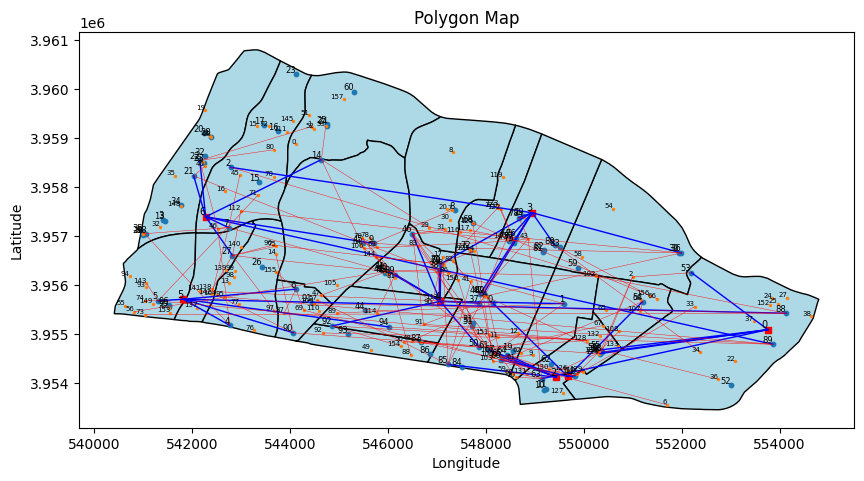

In [300]:
BestChromosom_Plot()